In [1]:
import os

import stimuli
import deepdish as dd

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.fftpack import fft, fftshift, fftfreq
from scipy.interpolate import interp1d
import pandas as pd

import pyret.filtertools as ft
import torchdeepretina as tdr
import torchdeepretina.stimuli as s
from torchdeepretina.io import load_model

from tqdm import tqdm


f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [2]:
prename = "convgc_"
prepath = '/home/grantsrb/src/torch-deep-retina/models/'
DATAFILE = prename+'nonlin_slopes_all.h5'
DEVICE = torch.device('cuda:0')
savefolder = "FigureUpdates_March2023/"
caption_file = "captions.txt"

In [3]:
def signfix(taus):
    """Corrects sign of a temporal kernel."""
    new_taus = []
    for tau in taus:
        if np.mean(tau[25:]) > 0:
            new_taus.append(-tau)
        else:
            new_taus.append(tau)
    return np.stack(new_taus)


def cadapt(contrasts, mdls):
    """Runs contrast adaptation analysis."""
    
    celldata = []
    for mdl in mdls:
        nc = mdl.n_units
        mdl.cuda()
        mdl.eval()
        for ci in range(nc):
            taus = []
            for c in tqdm(contrasts):
                X = s.concat(s.white(200, nx=50, contrast=c))
                X = torch.FloatTensor(X).cuda()
                X.requires_grad = True
                pred = mdl(X)[:,ci]
                pred.sum().backward()
                g = X.grad.data.detach().cpu().numpy()
                rf = g.mean(axis=0)
                _, tau = ft.decompose(rf)
                taus.append(tau)
            celldata.append(signfix(np.stack(taus)))
        mdl.cpu()
    return np.stack(celldata)


def center_of_mass(f, p):
    return np.sum(f * p)

def latenc(mdls, intensities):
    rates = []
    for i in tqdm(intensities):
        X = s.concat(s.flash(2, 40, 70, intensity=i))
        X = torch.FloatTensor(X).cuda()
        preds = []
        for mdl in mdls:
            mdl.cuda()
            mdl.eval()
            #pred = mdl(X).detach().cpu().numpy()[:,i:i+1]
            pred = mdl(X).detach().cpu().numpy()
            preds.append(pred)
            mdl.cpu()
        r = np.hstack(preds)
        rates.append(r)
    return np.stack(rates)


def upsample_single(tau, t, t_us):
    return interp1d(t, tau, kind='cubic')(t_us)


def upsample(taus, t, t_us):
    return np.stack([upsample_single(tau, t, t_us) for tau in taus])


def npower(x):
    """Normalized Fourier power spectrum."""
    amp = np.abs(fft(x))
    power = amp ** 2
    return power / power.max()


def get_slopes(model, contrasts):
    model.to(DEVICE)
    table = {"contrast":[], "slope":[]}
    for contr in contrasts:
        for i in range(model.n_units):
            slope = get_nonlin_slope(model, contr, i)
            table['contrast'].append(contr)
            table['slope'].append(slope)
    return table


def get_nonlin_slope(model, contr, unit_idx):
    layer_name = "sequential." + str(len(model.sequential)-1)
    tup = tdr.retinal_phenomena.filter_and_nonlinearity(model, contr, layer_name=layer_name,
                                      unit_index=unit_idx, verbose=True,
                                      nonlinearity_type='bin')
    time, temporal, x, nl, nonlinearity = tup
    slope = 0
    for i in range(1,len(time)):
        slope += (nl[0]-nl[i])/(time[0]-time[i])
    return slope/(len(time)-1)


def generate_data(min_contrast=0.5, max_contrast=2.0, num_contrasts=4):
    """Generates data for the contrast adaptation figure."""
    contrasts = np.linspace(min_contrast, max_contrast, num_contrasts)
    t = np.linspace(-400, 0, 40)
    t_us = np.linspace(-400, 0, 1000)

    kn1 = load_model(prepath+prename+'15-10-07_naturalscene.pt')
    kn2 = load_model(prepath+prename+'15-11-21a_naturalscene.pt')
    kn3 = load_model(prepath+prename+'15-11-21b_naturalscene.pt')
    nats = [kn1,kn2,kn3]
    for nat in nats:
        nat.eval()
    
    ns = cadapt(contrasts, nats)                      # Get temporal kernels
    ncells = sum([nat.n_units for nat in nats])
    nss = upsample(ns.reshape(ncells*num_contrasts, -1), t, t_us).reshape(ncells, num_contrasts, 1000) # Upsample kernels
    Fns = np.stack([npower(ni) for ni in nss])                      # FFT analysis
    nat_slopes = get_slopes(kn1, contrasts)

    # Load white noise models.
    km1 = load_model(prepath+prename+'15-10-07_whitenoise.pt')
    km2 = load_model(prepath+prename+'15-11-21a_whitenoise.pt')
    km3 = load_model(prepath+prename+'15-11-21b_whitenoise.pt')
    whits = [km1,km2,km3]
    for whit in whits:
        whit.eval()
        
    wn = cadapt(contrasts, whits)
    wns = upsample(wn.reshape(ncells*num_contrasts, -1), t, t_us).reshape(ncells, num_contrasts, 1000)
    Fwn = np.stack([npower(ni) for ni in wns])
    whit_slopes = get_slopes(km1, contrasts)

    slopes = {"naturalscene":nat_slopes, "whitenoise":whit_slopes}

    freqs = fftfreq(1000, 1e-3 * np.mean(np.diff(t_us)))

    data = {
        'ns': ns,
        'contrasts': contrasts,
        'nss': nss,
        't': t,
        't_us': t_us,
        'wn': wn,
        'wns': wns,
        'Fns': Fns,
        'Fwn': Fwn,
        'freqs': freqs,
        'slopes': slopes
    }
    dd.io.save(DATAFILE, data)
    return data




Using Data from convgc_nonlin_slopes_all.h5


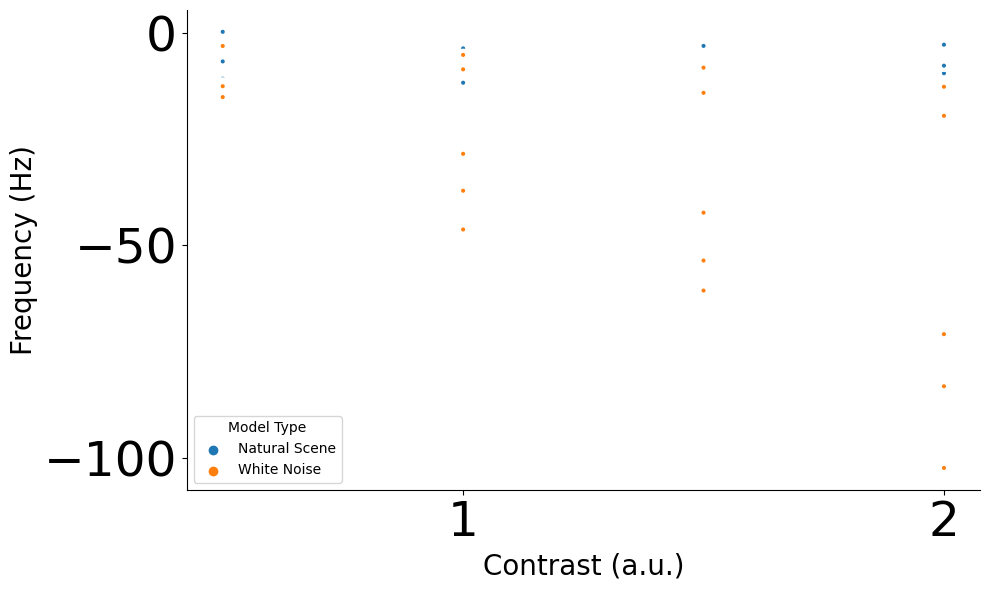

In [5]:
if os.path.exists(DATAFILE):
    print("Using Data from", DATAFILE)
    data = dd.io.load(DATAFILE)
else:
    print("Generating Data")
    data = generate_data()

nat_slopes = data['slopes']['naturalscene']
nat_df = pd.DataFrame(nat_slopes)
nat_df['Model Type'] = 'Natural Scene'
whit_slopes = data['slopes']['whitenoise']
whit_df = pd.DataFrame(whit_slopes)
whit_df['Model Type'] = 'White Noise'
df = nat_df.append(whit_df)

fig = plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="contrast",y="slope",hue="Model Type",data=df, linewidth=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

#ax.set_xlim(0.25, 2.25)
#ax.set_ylim(9, 16)
ax.set_xlabel('Contrast (a.u.)', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=20)
#ax.set_title('Center of mass of frequency response',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=35)
plt.locator_params(nbins=3)
plt.tight_layout()

#folder_name = "contrast_adapt"
#folder = os.path.join(savefolder, folder_name)
#if not os.path.exists(folder):
#    os.makedirs(folder)
#save_name = os.path.join(folder, prename+"nonlinslopes_all")
#plt.savefig(save_name + ".png", bbox_inches="tight")
#plt.savefig(save_name + ".pdf", bbox_inches="tight")
#plt.show()
#
#captions[folder_name][save_name.split("/")[-1]] = """
#"""
#
#with open(os.path.join(folder, caption_file), "w") as f:
#    for k,v in captions[folder_name].items():
#        f.write(k+":\n")
#        f.write(v+"\n\n")